## Ein Recommender System für Filme
* Collaborativer Item-Item Filter
* Szenario:
    * <font color=green>Eingabe:</font> ein Film (den der User gerade gesehen hat)
    * <font color=blue>Ausgabe:</font> Liste von Filmen die als nächstes geschaut werden könnten
<BR>    
<font color=red>"User die diesen Film gesehen haben, sahen auch ..."</font>

### Daten: freie Datenbank mit Filmbewertungen: http://www.movielens.org/
* 943 User, 1682 Filme und 100000 Bewertungen
* Download als CSV Datei
<img src="IMG/movielens.png" width=75%>

### Movielens Datenstrukturen
* Relationale Datendank mit drei Tabellen [users, ratings, movies]
<img src="IMG/mtable.png" width=75%>

### Datenimport:

In [1]:
#read data to DataFrames
import pandas as pd
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )


### Dann schauen wir uns die Daten doch mal an ...

In [2]:
import numpy as np
print (np.shape(users), np.shape(ratings), np.shape(movies))
print (ratings[1:10])
print ("hello")

(943, 5) (100000, 4) (1682, 24)
   user_id  movie_id  rating  timestamp
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
5      298       474       4  884182806
6      115       265       2  881171488
7      253       465       5  891628467
8      305       451       3  886324817
9        6        86       3  883603013
hello


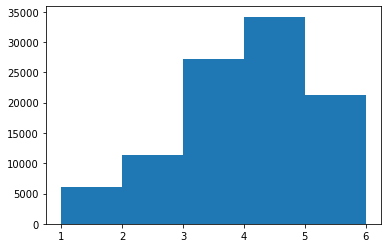

In [3]:
#schauen wir uns mal die die Verteilung der ratings an
import matplotlib.pyplot as plt
%matplotlib inline
res=plt.hist(ratings['rating'],[1,2,3,4,5,6])

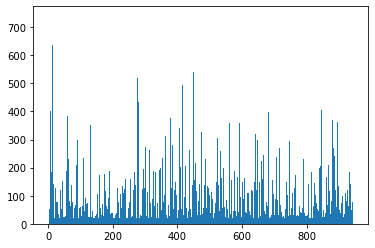

In [4]:
#wie viele Bewertungen geben user ab?
res=plt.hist(ratings['user_id'],943)

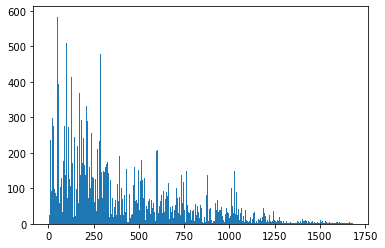

In [5]:
#wie oft werden Filme bewertet?
res=plt.hist(ratings['movie_id'],1682)

# Formalisierung: ein Item-Item Collaborative Filter

* User: $U := \{u_1, \dots, u_n\}, |U|=n$ <BR><BR>
* Filme (Produkte): $P := \{p_1, \dots, p_m\}, |P|=m$ <BR><BR>
* Kontext: Matrix $R$ der Größe $n\times m$<BR> mit Bewertungen $r_{ij},$ mit $ i\in 1\dots n, j\in 1\dots m$


In [6]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

### Plot $R$

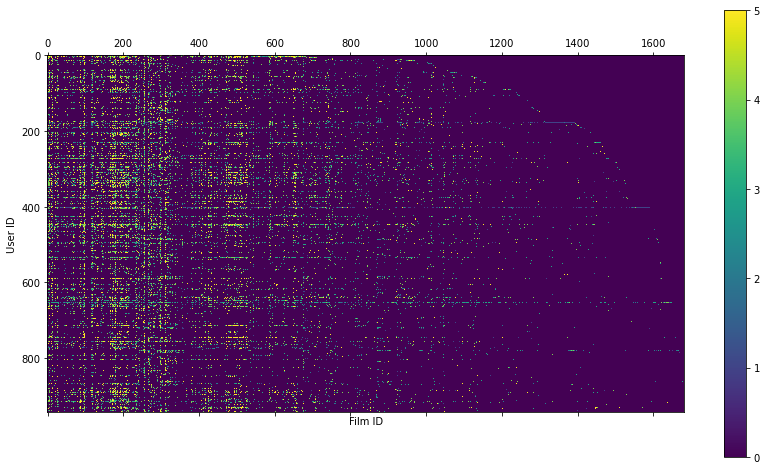

In [7]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
#show matrix    
plt.matshow(R)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()


## Distanzmaße 
<br>
In $R$ sind alle 
* Bewertungen des $i$-ten Films im $i$-ten Spaltenvektor abgelegt
* Bewertungen des $j$-ten Users im $j$-ten Zeilenvektor abgelegt 
<BR><BR>

### Filmbewertungen := Spaltenvektoren in der Kontext Matrix $R$
<img src="IMG/R.png">


### Items: Kosinus-Distanz:
Für Filmbewertungen := Spaltenvektoren $\vec{a},\vec{b}$ in $R$ gilt die Distanz:<BR><BR>
$d_{cos}(\vec{a},\vec{b}) := { <\vec{a},\vec{b}> \over |\vec{a}||\vec{b}|}$ <BR><BR>
* mit den Skalarprodukt $ <\vec{a},\vec{b}>$<BR>
* und der Vektornorm $|\vec{a}|$<BR>
* mit dem Wertebereich  zwischen $0$ (keine Ähnlichkeit) und $1$ (Identisch)<BR>


In [8]:
 def CosineDist(a,b):
    res =  a.dot(b)
    norm = np.linalg.norm(a)*np.linalg.norm(b)
    if norm > 0: #norm ist null wenn keine Berwerung existiert -> Fallunterscheidung
        return res/norm
    else:
        return res

# 4.1 Alternative Distanzberechnung: Manhattan Distanz

In [9]:
# calculate manhattan distance
def manhattan_distance(a, b):
    return np.sum(np.absolute(np.matrix(a)-np.matrix(b)))

### Erstelle Kosinus-Distanz Matrix für alle Filme (offline)

In [10]:
%%time
#again, implementation not efficient: better use lamda opperators (later in this course)
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

#again, implementation not efficient: better use lamda opperators (later in this course)
D_manh=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_manh[i,j]=manhattan_distance(R[:,i],R[:,j])

Wall time: 2min 46s


In [11]:
np.save("movie_dist_cos",D)
np.save("movie_dist_manhattan",D_manh)

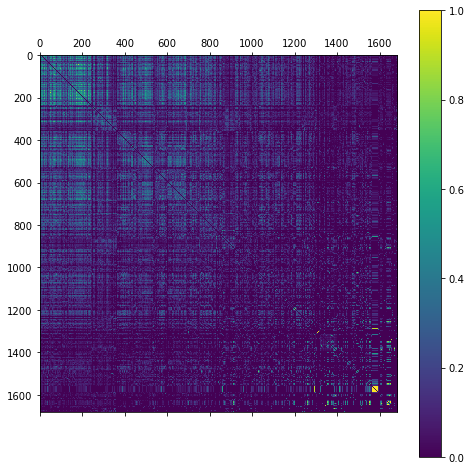

In [12]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D)
plt.colorbar() 

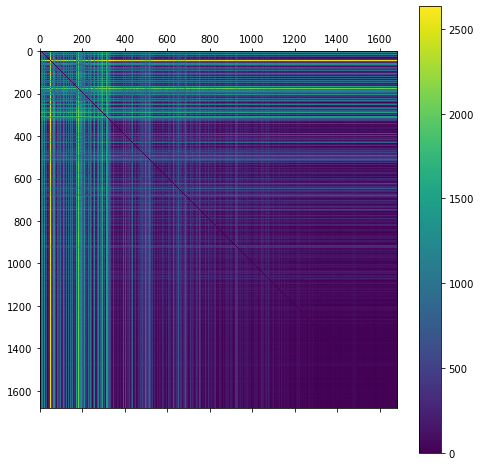

In [13]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_manh)
plt.colorbar() 

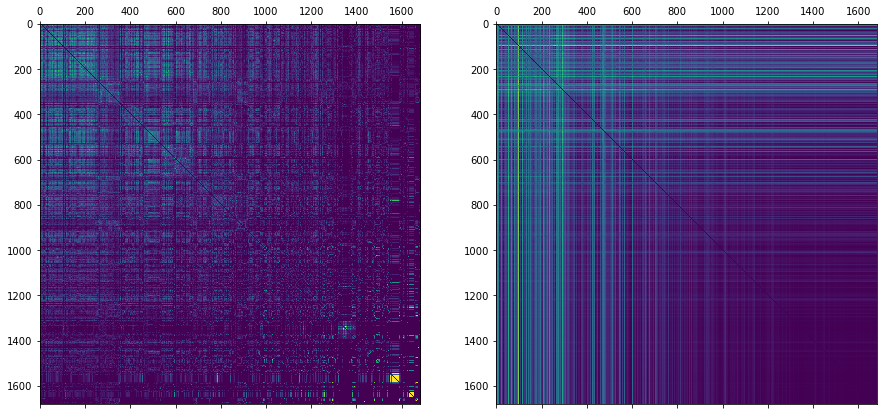

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.matshow(D)
ax2.matshow(D_manh)

### Anfragen an die Distanz-Matrix
* Suche die Top-5 ähnlichsten Filme 
* argmax auf Spalten / Zeilen von $D$
<img src="IMG/D.png" width="200">

In [43]:
def getTopN(movie_id,D, N=5):
    return D[movie_id,:].argsort()[-N:]


### Hilfsfunktionen

In [16]:
def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

## Implementierung Collaborative Item-Item Filter

In [17]:
def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        

In [18]:
print("D:")
CII("Casabl",D)

D:
recommending movies for: 'Casablanca (1942)'


133                                  Citizen Kane (1941)
131                             Wizard of Oz, The (1939)
483                           Maltese Falcon, The (1941)
473    Dr. Strangelove or: How I Learned to Stop Worr...
134                         2001: A Space Odyssey (1968)
Name: title, dtype: object

In [19]:
print("D_manh:")
CII("Casabl",D_manh)

D_manh:
recommending movies for: 'Casablanca (1942)'


257          Contact (1997)
299    Air Force One (1997)
287           Scream (1996)
293        Liar Liar (1997)
312          Titanic (1997)
Name: title, dtype: object

## Quallitätsicherung - wie gut ist unser System objekitv?
Zum testen werden die Daten in einen Trainingsdatensatz und in einen Testdatensatz gesplitettet.
Dabei wird der Trainingsdatensatz so gewählt, dass zufällig 90 % der Daten für das Training verwendet werden und 10 % der Daten für den Test wie gut
die Filmvorschläge auch wiurklich funktionieren

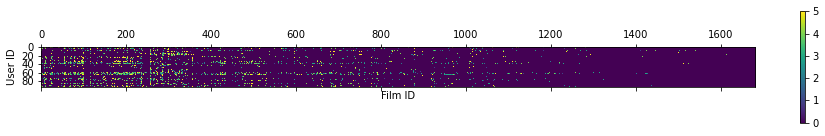

In [20]:
#split into train and test data
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)
plt.matshow(R_test)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()

In [21]:
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    

In [22]:
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

### Qualitätstest Cosinus Distnaz:
Hier wird erneut die Cosinusdistanz des Dasensatzes berechnet aber nur noch von den Traininghsdaten R_train der R_matrix

In [23]:
#again, implementation not efficient: better use lamda opperators (later in this course)
D_train=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_train[i,j]=CosineDist(R_train[:,i],R_train[:,j])

In [24]:
test_res_cos=test_Score(D_train,R_test)

(array([ 4.,  5., 16., 21., 11., 15.,  8.,  7.,  4.,  4.]),
 array([0.32 , 0.696, 1.072, 1.448, 1.824, 2.2  , 2.576, 2.952, 3.328,
        3.704, 4.08 ]),
 <BarContainer object of 10 artists>)

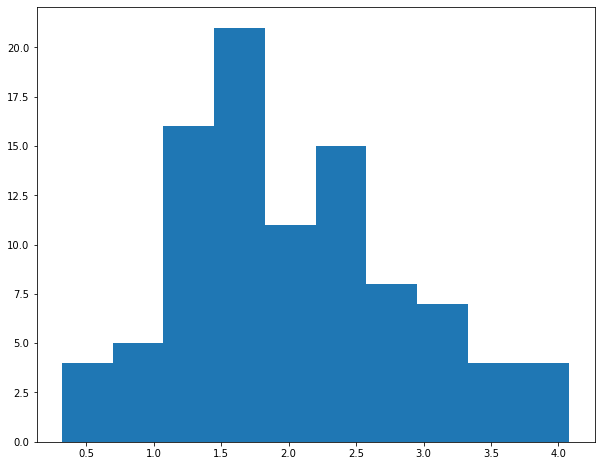

In [25]:
plt.hist(test_res_cos)

In [26]:
np.mean(test_res_cos)

2.046315789473684

### Qualitätstest Manhattan Distanz

In [27]:
#again, implementation not efficient: better use lamda opperators (later in this course)
D_manh_train=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_manh_train[i,j]=manhattan_distance(R_train[:,i],R_train[:,j])

In [28]:
test_res_manh=test_Score(D_manh_train,R_test)

(array([25., 13.,  8., 12., 13., 12.,  5.,  3.,  1.,  3.]),
 array([0.   , 0.428, 0.856, 1.284, 1.712, 2.14 , 2.568, 2.996, 3.424,
        3.852, 4.28 ]),
 <BarContainer object of 10 artists>)

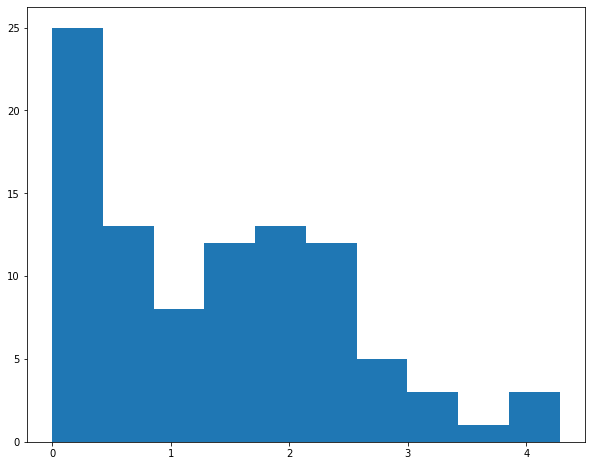

In [29]:
plt.hist(test_res_manh)

In [46]:
print("Testergebnis Manhattan Distanz:  ", np.mean(test_res_manh))
print("Testergebnis Cosinus Distanz:    ", np.mean(test_res_cos))

Testergebnis Manhattan Distanz:   1.3583157894736841
Testergebnis Cosinus Distanz:     2.046315789473684


# 4.2 Basline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [31]:
 def random_movie(D):
    random_mov =np.zeros(5)
    random_mov = np.random.randint(D.shape[1], size=(5))
    return random_mov

In [32]:
#es wird durch die ANzahl an Ratings geteilt
def best_five_movies_1 (D):
    ranking_sum = np.zeros(np.shape(D)[1])
    number_of_ratings = np.zeros(np.shape(D)[1])
    mask = D>0
    for i in range(0,R.shape[1],1): #film_id
        ranking_sum[i] = np.sum(D[:,i]) #get the values of a column
        #checking for number of ratings
        number_of_ratings[i] = np.sum(mask[:,i])
    ranking_sum = ranking_sum /number_of_ratings   
    return np.argsort(ranking_sum)[-5:]
    

In [33]:
#Es wird einfach die Summe der einzeldistanzen betrachtet
def best_five_movies_2 (D):
    ranking_sum = np.zeros(np.shape(D)[1])
    for i in range(0,R.shape[1],1): #film_id
        ranking_sum[i] = np.sum(D[:,i]) #get the values of a column
    return np.argsort(ranking_sum)[-5:]

In [34]:
def Score_byID_random(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = random_movie(D)
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

In [35]:
def Score_byID_top5(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = best_five_movies_2(D)
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

In [36]:
#compute scores for all test users
def test_Score_random(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID_random(e,D_train, R_test[i]) #hier randomscore by id
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [37]:
#compute scores for all test users
def test_Score_top5(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID_top5(e,D_train, R_test[i]) #hier top5 by id
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

#### Test der Funktionen

In [38]:
#Best_five_movies_1
print("Id of the best five movies")
best_5_R = best_five_movies_1(R)
print("R:           ", best_5_R)
best_5_D = best_five_movies_1(D)
print("CosineDist:  ", best_5_D)
best_5_D_manh = best_five_movies_1(D_manh)
print("ManhDist:    ", best_5_D_manh)

Id of the best five movies
R:            [1121  813 1652 1466 1292]
CosineDist:   [1665 1664 1662 1669 1668]
ManhDist:     [285 257 180  99  49]


In [39]:
#Best_five_movies_2, Betrachtung der SUmmen der Distanzen
print("Id of the best five movies")
best_5_R = best_five_movies_2(R)
print("R:           ", best_5_R)
best_5_D = best_five_movies_2(D)
print("CosineDist:  ", best_5_D)
best_5_D_manh = best_five_movies_2(D_manh)
print("ManhDist:    ", best_5_D_manh)

Id of the best five movies
R:            [173 257 180  99  49]
CosineDist:   [ 78  55 171 173 203]
ManhDist:     [285 257 180  99  49]


## Quality Check

In [40]:
test_res_random=test_Score_random(D_manh_train,R_test)
test_res_top5=test_Score_top5(D_manh_train,R_test)

In [49]:
print("Random:     ",np.mean(test_res_random))
print("Top5:       ",np.mean(test_res_top5))
print("Manh Dist:  ", np.mean(test_res_manh))
print("Cos Dist:   ", np.mean(test_res_cos))

Random:      0.19789473684210526
Top5:        1.9242105263157903
Manh Dist:   1.3583157894736841
Cos Dist:    2.046315789473684


# 4.3 SVD-Singulärwertzerlegung
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$

In [57]:
U,S,V =np.linalg.svd(D_train)
np.shape(S)

(1682,)

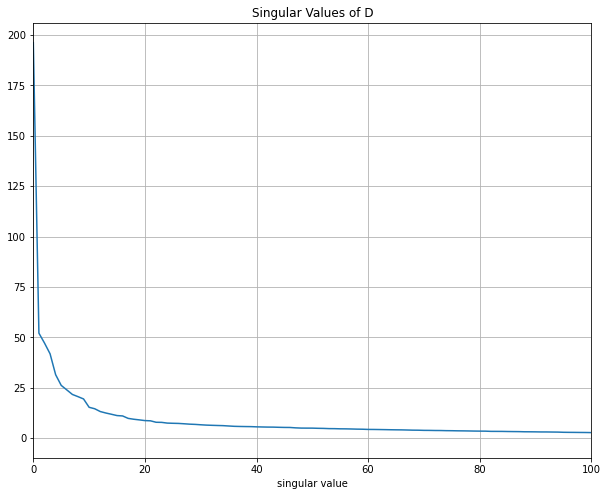

In [58]:
fig, sing = plt.subplots()
sing.plot(S)
sing.set_xlim([0,100])
sing.set_xlabel("singular value")
sing.set_title("Singular Values of D")

sing.grid(True)

In [59]:
# now reconstruct with loss
# using only the 40 of 1682 singular values
numof_singular_val = 40
D_new = np.dot(U[:,:numof_singular_val]*S[:numof_singular_val],V[:numof_singular_val,:])


### Tests with de reduced D

In [60]:
D_old = D_train
print("D old:")
CII("Star",D_old)

D old:
recommending movies for: 'Star Wars (1977)'


180                    Return of the Jedi (1983)
173               Raiders of the Lost Ark (1981)
171              Empire Strikes Back, The (1980)
0                               Toy Story (1995)
209    Indiana Jones and the Last Crusade (1989)
Name: title, dtype: object

In [61]:
print("D new:")
CII("Star",D_new)

D new:
recommending movies for: 'Star Wars (1977)'


49                    Star Wars (1977)
173     Raiders of the Lost Ark (1981)
180          Return of the Jedi (1983)
171    Empire Strikes Back, The (1980)
203          Back to the Future (1985)
Name: title, dtype: object

Es zeigt sich das man durch die Reduzierung der Matrix trozdem fast die selben vorschläge erhällt

Text(0.5, 1.0, 'D new')

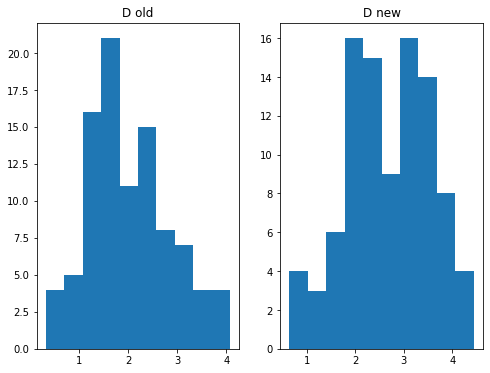

In [62]:
test_res_D_old = test_Score(D_old,R_test)
test_res_D_new = test_Score(D_new,R_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6))

ax1.hist(test_res_D_old)
ax1.set_title('D old')
ax2.hist(test_res_D_new)
ax2.set_title('D new')

In [63]:
print('mean value D old:', np.mean(test_res_D_old))
print('mean value D new:', np.mean(test_res_D_new))

mean value D old: 2.046315789473684
mean value D new: 2.678736842105263
